In [1]:
import pickle
import torch
import random
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
#import seaborn as sns
from sklearn.manifold import TSNE
from linclab_utils import plot_utils
import torchvision.transforms as T
from torchvision import datasets
from torch.utils.data import DataLoader, Subset

from sklearn.metrics import silhouette_score
from scipy.spatial import distance_matrix

from connectome_to_model.utils.audio_dataset import AudioVisualDataset
from connectome_to_model.model.graph import Graph, Architecture
#from connectome_to_model.model.graph_legacy import Graph, Architecture
from connectome_to_model.model.readouts import ClassifierReadout

In [2]:
def extract_mean_and_std(list_of_dict, num_epochs):
    mean_array = np.zeros((4, 2, num_epochs))
    
    for i, result in enumerate(['amb_match_acc', 'clean_mismatch_acc', 'ambimg_acc', 'ambimg_audio_align']):
        array = np.zeros((len(list_of_dict), num_epochs))
        for trial_num, run in enumerate(list_of_dict):
            array[trial_num] = run[result]
        
        mean_array[i][0] = np.mean(array, axis=0) 
        mean_array[i][1] = np.std(array, axis=0)
    
    return mean_array

In [3]:
def extract_mean_and_std_V2(list_of_dict, num_epochs):
    scenarios = ['amb_match_acc', 'clean_mismatch_acc', 'control_img_align', 'control_audio_align', 'allamb_img_align', 'allamb_audio_align']
    mean_array = np.zeros((len(scenarios), 2, num_epochs))
    
    for i, result in enumerate(scenarios):
        array = np.zeros((len(list_of_dict), num_epochs))
        for trial_num, run in enumerate(list_of_dict):
            array[trial_num] = run[result]
        
        mean_array[i][0] = np.mean(array, axis=0) 
        mean_array[i][1] = np.std(array, axis=0)
    
    return mean_array

In [4]:
def make_error_plot(ax, graphs, labels, colors, test_idx):
    x = np.arange(0, 50)
    for i, graph in enumerate(graphs):
        ax.fill_between(x, graph[test_idx][0]-graph[test_idx][1], 
                 graph[test_idx][0]+graph[test_idx][1], color=colors[i], alpha=0.3)
        ax.plot(graph[test_idx][0], label=labels[i], color=colors[i])

## Dimensionality reduction

In [5]:
amb_match_root='/home/mila/m/mashbayar.tugsbayar/datasets/multimodal_amb_match'
#amb_match_root='/network/scratch/m/mashbayar.tugsbayar/datasets/audiovisual_brainlike/aum'
clean_mismatch_root='/home/mila/m/mashbayar.tugsbayar/datasets/multimodal_clean_mismatch'
amb_mismatch_root='/home/mila/m/mashbayar.tugsbayar/datasets/multimodal_amb_mismatch'

t_transforms = lambda y: torch.tensor(y).cpu()

#match_testset = AudioVisualDataset(None, None, cache_dir=amb_match_root, split='test', transforms=T.Resize((32,32)), target_transforms=t_transforms)
match_testset = AudioVisualDataset(None, None, cache_dir=amb_match_root, split='test')
mismatch_testset = AudioVisualDataset(None, None, cache_dir=clean_mismatch_root, split='test')
control_testset = AudioVisualDataset(None, None, cache_dir=amb_mismatch_root, split='test')

In [6]:
transform = T.Compose([T.Resize((32, 32)), T.ToTensor()])
MNIST_path='/home/mila/m/mashbayar.tugsbayar/datasets'
match_testset = datasets.MNIST(root=MNIST_path, download=True, train=False, transform=transform)

In [8]:
input_nodes = [0, 4] # V1, A1
output_node = 3 #IT
graph_loc = 'graphs/multimodal_brainlike.csv'
model_save = 'saved_models/ambimg_brainlike/big_rnn_2.pt'

graph = Graph(graph_loc, input_nodes=input_nodes, output_nodes=output_node)
input_sizes = graph.find_input_sizes()
input_dims = graph.find_input_dims()

# INIT MODEL
model = Architecture(graph, input_sizes, input_dims).cuda().float()
model.load_state_dict(torch.load(model_save))
model.eval()

/home/mila/m/mashbayar.tugsbayar/.conda/envs/con2model/lib/python3.11/site-packages/torch/nn/init.py:412: UserWarning: Initializing zero-element tensors is a no-op
  warnings.warn("Initializing zero-element tensors is a no-op")


Architecture(
  (dropout): Dropout(p=0.25, inplace=False)
  (cell_list): ModuleList(
    (0): ConvGRUBasalTopDownCell(
      (conv_gates): Conv2d(11, 20, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (conv_can): Conv2d(11, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    )
    (1-2): 2 x ConvGRUBasalTopDownCell(
      (conv_gates): Conv2d(20, 20, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (conv_can): Conv2d(20, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    )
    (3): ConvGRUBasalTopDownCell(
      (conv_gates): Conv2d(20, 20, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (conv_can): Conv2d(20, 10, kernel_size=(1, 1), stride=(1, 1), bias=False)
    )
    (4): ConvGRUBasalTopDownCell(
      (conv_gates): Conv2d(11, 20, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (conv_can): Conv2d(11, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    )
    (

In [9]:
readout_save = 'saved_models/ambimg_brainlike/big_rnn2_classifier.pt'
readout = ClassifierReadout(model.output_sizes[0], n_classes=10).cuda().float()
readout.load_state_dict(torch.load(readout_save))
readout.eval()

ClassifierReadout(
  (fc1): Linear(in_features=160, out_features=100, bias=True)
  (fc2): Linear(in_features=100, out_features=10, bias=True)
)

In [10]:
match_testset[0][0][0].shape

torch.Size([1, 32, 32])

In [5]:
import umap

In [44]:
from sklearn.decomposition import PCA

In [10]:
datapoints = 1000
#labels = [3, 5, 8]
#indices = [idx for idx, target in enumerate(match_testset.targets) if target[0] in labels or target[1] in labels]
#dataloader = DataLoader(Subset(match_testset, indices), batch_size=datapoints, shuffle=False)
dataloader = DataLoader(mismatch_testset, batch_size=datapoints, shuffle=True)
align_to = 'image'
label_idx = 1 if align_to == 'audio' else 0
device= 'cuda'

classifier_h_states = torch.zeros(7, datapoints, 3)
reduced_hstates = torch.zeros(7, 7, datapoints, 3)

#for t in range(7):
for i, data in enumerate(dataloader, 0):
    with torch.no_grad():    
        #x, label = next(iter(dataloader))
        x, label = data
        label = torch.unsqueeze(label[label_idx], 1)
        
        x = [torch.unsqueeze(inp, 1).to(device).float() for inp in x if inp.ndim != 5]
        #x = [x[0], x[0]]
        #x = [torch.unsqueeze(x, 1).to(device).float()]
        #label = torch.unsqueeze(label, 1)
        
        output = model(x, process_time=t+1)
        #output = [o.flatten(start_dim=1).cpu() for o in output]
        output = readout(output[0]).cpu()

        _, predicted = torch.max(output.data, 1)
        correct = (predicted == label[:, 0]).sum().item()
        print(correct)
            
        #for area in range(7):
            #tsne = TSNE(n_components=2, perplexity=10, random_state=42)
        #    tsne = umap.UMAP()
        #    if torch.count_nonzero(output[area]) == 0:
        #        tsne_results = torch.zeros(datapoints, 2)
        #    else:
        #        tsne_results = torch.tensor(tsne.fit_transform(output[area]))
        #    reduced_hstates[t, area] = torch.cat((tsne_results, label), dim=1)

NameError: name 't' is not defined

In [5]:
reduced_hstates = pd.read_pickle('dim_red/dim_red_tsne_random2_mismatch_dud.npy')

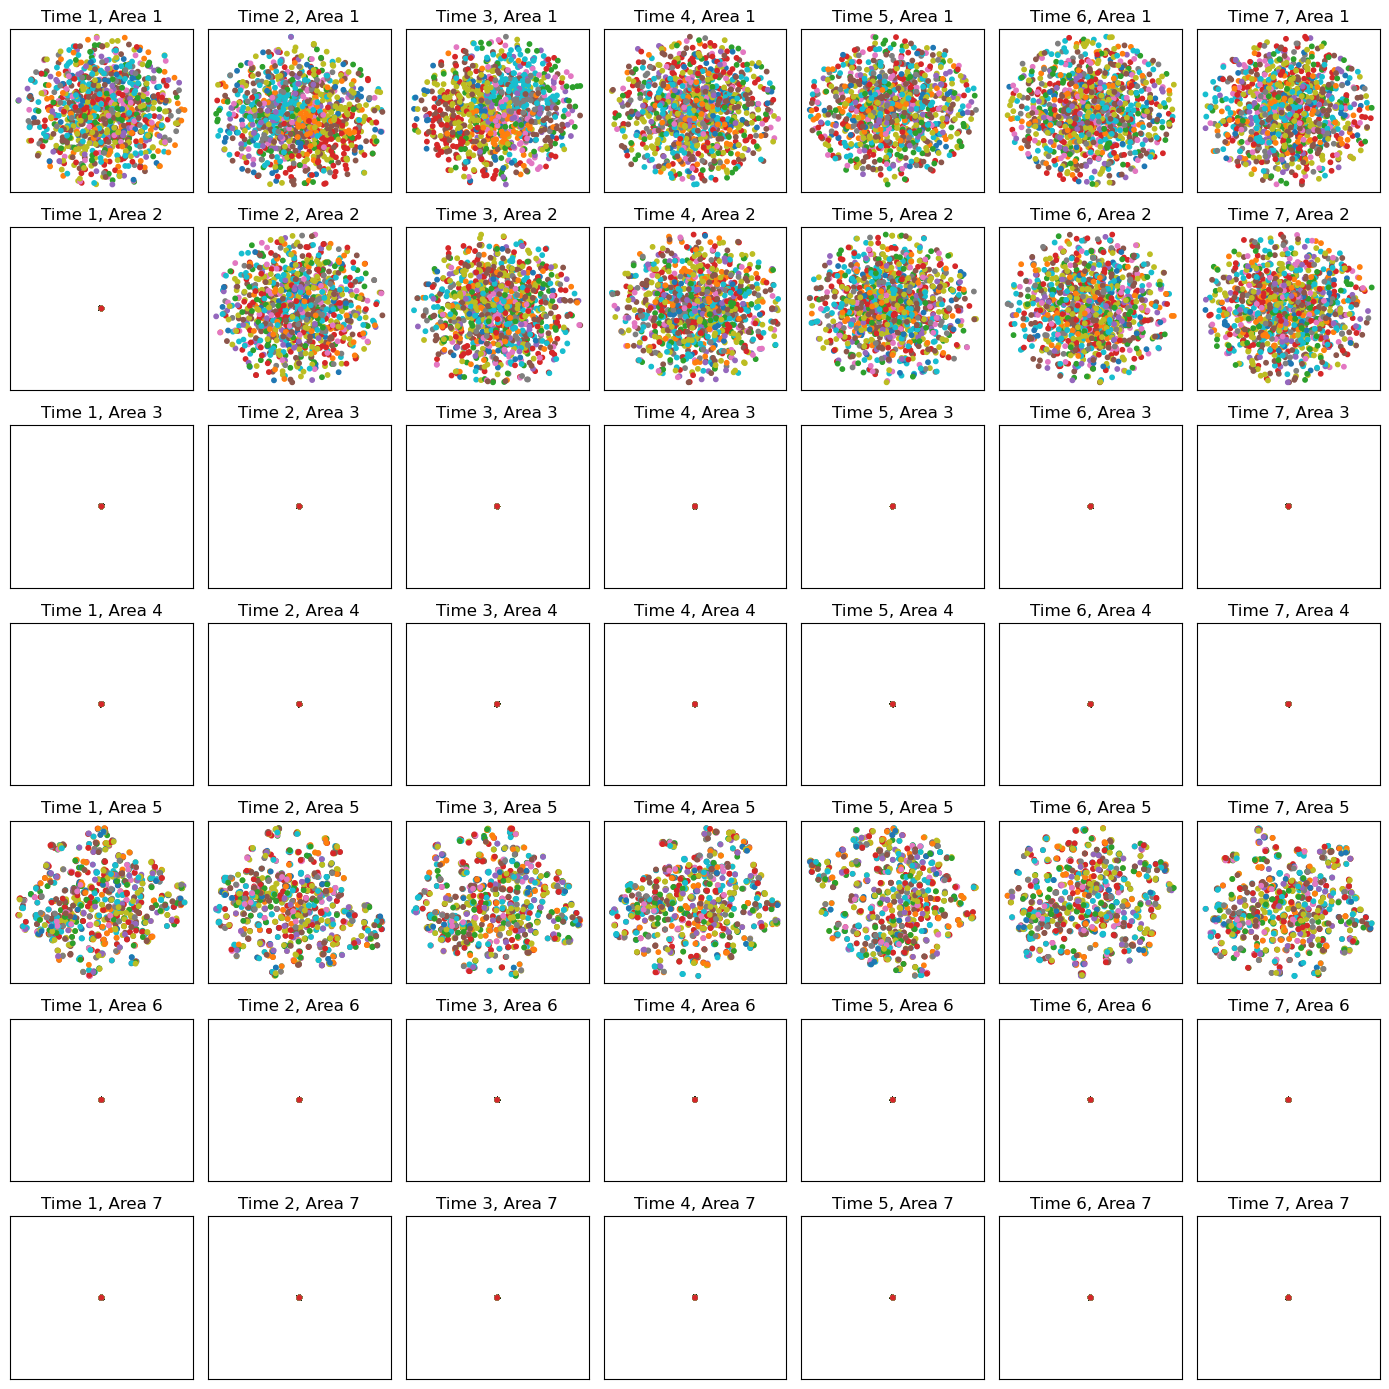

In [6]:
fig, axes = plt.subplots(7, 7, figsize=(14, 14))
    
for i in range(7):
    for j in range(7):
        # Extract data points for the current grid element
        grid_data = reduced_hstates[j, i, :, :2]
        labels = reduced_hstates[j, i, :, 2]

        # Plot data points
        axes[i, j].scatter(grid_data[:, 0], grid_data[:, 1], c=labels, s=10, cmap='tab10')
        axes[i, j].set_title(f"Time {j+1}, Area {i+1}")
        axes[i, j].set_xticks([])
        axes[i, j].set_yticks([])

# Adjust layout
plt.tight_layout()
#plt.savefig('figs/dim_red_random2_mismatch.pdf')
plt.show()

torch.Size([1000, 2])
torch.Size([1000, 2])
torch.Size([1000, 2])
torch.Size([1000, 2])
torch.Size([1000, 2])
torch.Size([1000, 2])
torch.Size([1000, 2])


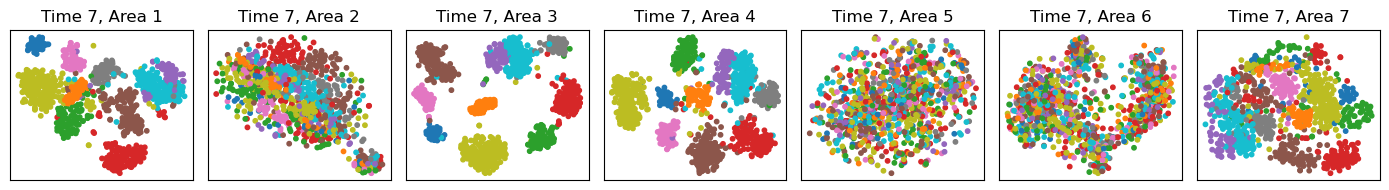

In [13]:
fig, axes = plt.subplots(1, 7, figsize=(14, 2))
    
for i in range(7):
        # Extract data points for the current grid element
        grid_data = reduced_hstates[6, i, :, :2]
        labels = reduced_hstates[6, i, :, 2]
        print(grid_data.shape)

        # Plot data points
        axes[i].scatter(grid_data[:, 0], grid_data[:, 1], c=labels, s=10, cmap='tab10')
        axes[i].set_title(f"Time {j+1}, Area {i+1}")
        axes[i].set_xticks([])
        axes[i].set_yticks([])

# Adjust layout
plt.tight_layout()
plt.savefig('figs/dim_red_random2_mismatch_final_area.pdf')
plt.show()

In [ ]:
fig, axes = plt.subplots(1, 7, figsize=(28, 4))
    
for i in range(7):
    # Extract data points for the current grid element
    grid_data = reduced_hstates[i, :, :2]
    labels = reduced_hstates[i, :, 1]

    # Plot data points
    axes[i].scatter(grid_data[:, 0], grid_data[:, 1], c=labels, s=10, cmap='tab10')
    axes[i].set_title(f"Time {i+1}")
    axes[i].set_xticks([])
    axes[i].set_yticks([])

# Adjust layout
plt.tight_layout()
plt.show()

## Clustering analysis

In [5]:
from scipy.spatial.distance import pdist, squareform

def intralabel_interlabel_distance(data):
    labels = np.unique(data[:, 2])  # Extract unique labels
    intralabel_distances = []
    interlabel_distances = []

    for label in labels:
        # Extract data points for the current label
        label_data = data[data[:, 2] == label][:, :2]
        
        # Calculate pairwise distances within the label group
        intralabel_dist = pdist(label_data)
        intralabel_distances.append(np.mean(intralabel_dist))
        
        # Calculate pairwise distances with other label groups
        other_data = data[data[:, 2] != label][:, :2]
        interlabel_dist = pdist(np.vstack((label_data, other_data)))
        interlabel_distances.append(np.mean(interlabel_dist))
    
    intralabel_distances = np.mean(intralabel_distances)
    interlabel_distances = np.mean(interlabel_distances)
    
    # Calculate the ratio of intralabel distance to interlabel distance
    ratio = intralabel_distances / interlabel_distances
    
    return intralabel_distances, interlabel_distances, ratio

In [6]:
intralabel_dist, interlabel_dist, ratio = intralabel_interlabel_distance(reduced_hstates[0, 0])
print("Intralabel distances:", intralabel_dist)
print("Interlabel distances:", interlabel_dist)
print("Ratio of intralabel distance to interlabel distance:", ratio)

NameError: name 'reduced_hstates' is not defined

In [7]:
intralabel_dist, interlabel_dist, ratio = intralabel_interlabel_distance(reduced_hstates[6, 0])
print("Intralabel distances:", intralabel_dist)
print("Interlabel distances:", interlabel_dist)
print("Ratio of intralabel distance to interlabel distance:", ratio)

Intralabel distances: 7.744060658506498
Interlabel distances: 26.821274256192066
Ratio of intralabel distance to interlabel distance: 0.2887282902570773


In [ ]:
def compute_ratios(input_data):
    num_labels = input_data.shape[0]
    ratios_matrix = np.zeros((num_labels, num_labels))
    
    for i in range(num_labels):
        for j in range(num_labels):
            intralabel_dist, interlabel_dist, ratio = intralabel_interlabel_distance(input_data[i, j])
            ratios_matrix[j, i] = ratio
    
    return ratios_matrix

In [8]:
def compute_sratios(input_data, align='image'):
    num_labels = input_data.shape[0]
    ratios_matrix = np.zeros((num_labels, num_labels))
    
    for i in range(num_labels):
        for j in range(num_labels):
            #ntralabel_dist, interlabel_dist, ratio = intralabel_interlabel_distance(input_data[i, j])
            data = input_data[i, j, :, 0:2]
            label = input_data[i, j, :, 2] if align == 'image' else input_data[i, j, :, -1]
            ratio = neighborhood_hit_score(data, label)
            ratios_matrix[j, i] = ratio
    
    return ratios_matrix

In [23]:
def neighborhood_hit_score(data, labels, k=4):
    # Calculate the distance matrix
    dist_matrix = distance_matrix(data, data)
    
    n = data.shape[0]
    hit_scores = torch.zeros(n)
    
    for i in range(n):
        # Sort the distances to find the k nearest neighbors (excluding the point itself)
        sorted_indices = np.argsort(dist_matrix[i])
        
        # Exclude the first point (itself)
        nearest_neighbors = sorted_indices[1:k+1]
        
        # Count how many of the k nearest neighbors share the same label
        #print(labels[nearest_neighbors] == labels[i])
        same_label_count = torch.count_nonzero(labels[nearest_neighbors] == labels[i])
        
        # Calculate the proportion of neighbors with the same label
        hit_scores[i] = same_label_count / k
    
    # The Neighborhood Hit Score is the average of these proportions
    return torch.mean(hit_scores)

In [17]:
brainlike_reduced_hstates = pd.read_pickle('dim_red/dim_red_tsne_brainlike_mismatch.npy')
mpc_reduced_hstates = pd.read_pickle('dim_red/dim_red_tsne_mpc_mismatch.npy')
random_reduced_hstates = pd.read_pickle('dim_red/dim_red_tsne_random2_mismatch.npy')
big_rnn_reduced_hstates = pd.read_pickle('dim_red/dim_red_tsne_big_rnn_mismatch.npy')

brainlike_ratios = compute_sratios(brainlike_reduced_hstates)
mpc_ratios = compute_sratios(mpc_reduced_hstates)
random_ratios = compute_sratios(random_reduced_hstates)
big_rnn_ratios = compute_sratios(big_rnn_reduced_hstates)

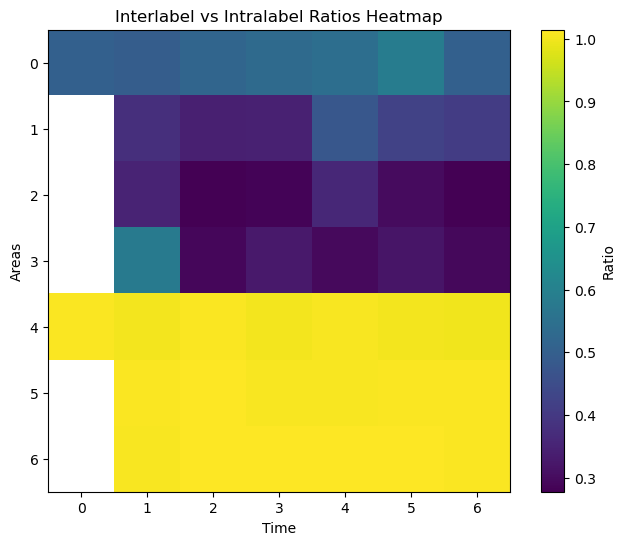

In [7]:
plt.figure(figsize=(8, 6))
plt.imshow(brainlike_ratios, cmap='viridis', interpolation='nearest')
plt.colorbar(label='Ratio')
plt.title('Interlabel vs Intralabel Ratios Heatmap')
plt.xlabel('Time')
plt.ylabel('Areas')
plt.savefig('fig5_heatmap.pdf')
plt.show()

In [23]:
random_ratios[6]

array([       nan, 1.00837156, 1.00711735, 1.00552382, 0.39444965,
       0.52937133, 0.62650377])

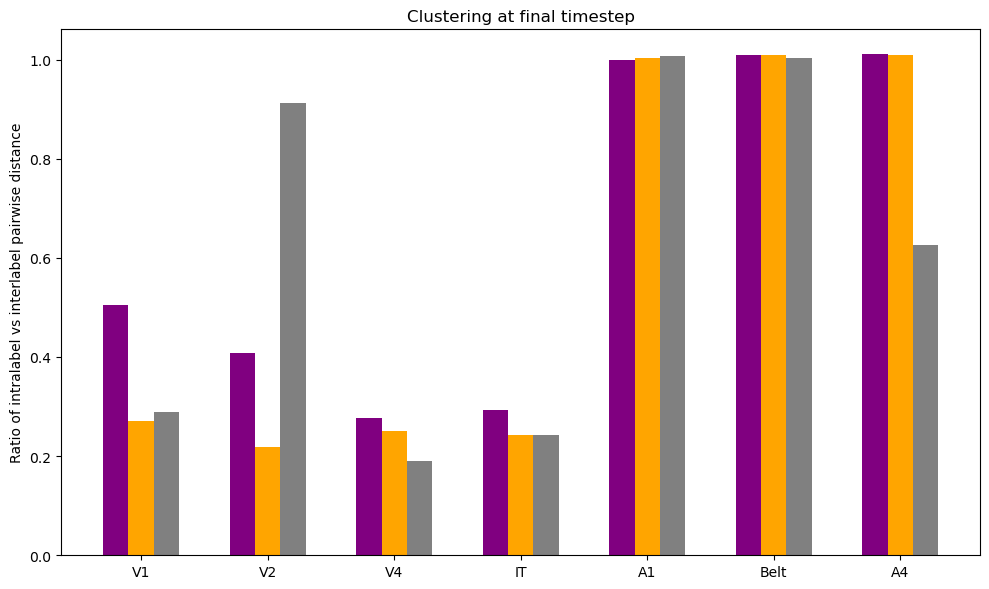

In [33]:
positions = np.arange(len(brainlike_ratios[:, 6]))

# Plotting the bar plots with clustering of bars of the same mean together
fig, ax = plt.subplots(figsize=(10, 6))

# Plot bars for array 1
ax.bar(positions - 0.2, brainlike_ratios[:, 6], width=0.2, color='purple', label='Array 1')

# Plot bars for array 2
ax.bar(positions, mpc_ratios[:, 6], width=0.2, color='orange', label='Array 2')

# Plot bars for array 3
ax.bar(positions + 0.2, random_ratios[:, 6], width=0.2, color='grey', label='Array 3')

# Set ticks and labels
ax.set_xticks(positions)
ax.set_xticklabels(['V1', 'V2', 'V4', 'IT', 'A1', 'Belt', "A4"])
ax.set_title('Clustering at final timestep')
ax.set_ylabel('Ratio of intralabel vs interlabel pairwise distance')

plt.tight_layout()
plt.show()

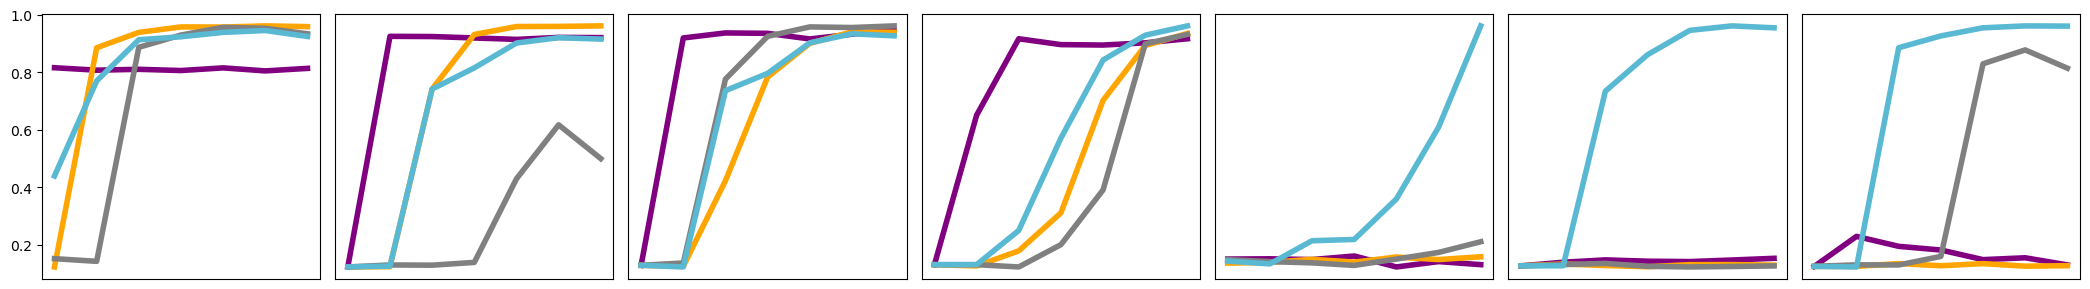

In [18]:
positions = np.arange(len(brainlike_ratios[:, 6]))

# Plotting the bar plots with clustering of bars of the same mean together
fig, ax = plt.subplots(1, 7, figsize=(21, 3))

# Plot bars for array 1
for i, area in enumerate([0, 1, 2, 3, 4, 5, 6]):
    ax[i].plot(brainlike_ratios[area], color='purple', label='Array 1', linewidth=4)
    ax[i].plot(mpc_ratios[area], color='orange', label='Array 2', linewidth=4)
    ax[i].plot(random_ratios[area], color='grey', label='Array 3', linewidth=4)
    ax[i].plot(big_rnn_ratios[area], color='#59B9D2', label='Array 3', linewidth=4)
    
    #ax[i].set_ylim([-0.5, 1])
    ax[i].set_xticks([])
    if i != 0:
        ax[i].set_yticks([])

# Set ticks and labels
plt.tight_layout()
plt.savefig('figs/fig5_cluster_analysis_mismatch_sratios.pdf')
plt.show()

AttributeError: 'numpy.ndarray' object has no attribute 'set_xticks'

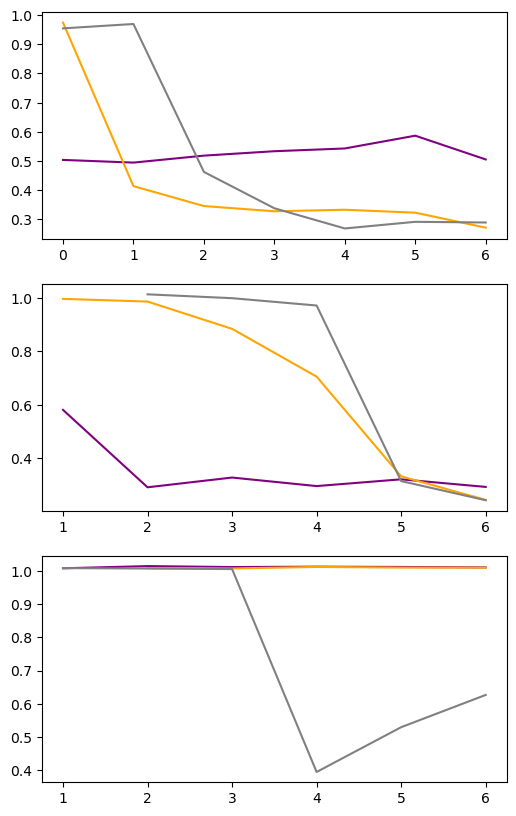

In [9]:
positions = np.arange(len(brainlike_ratios[:, 6]))

# Plotting the bar plots with clustering of bars of the same mean together
fig, ax = plt.subplots(3, 1, figsize=(6, 10))

# Plot bars for array 1
for i, area in enumerate([0, 3, 6]):
    ax[i].plot(brainlike_ratios[area], color='purple', label='Array 1')
    ax[i].plot(mpc_ratios[area], color='orange', label='Array 2')
    ax[i].plot(random_ratios[area], color='grey', label='Array 3')

# Set ticks and labels
ax.set_xticks(positions)
ax.set_xticklabels(['t0', 't1', 't2', 't3', 't4', 't5', "t6"])
ax.set_title('Formation of representation at IT across time, mismatch')

plt.tight_layout()
plt.show()

In [19]:
brainlike_reduced_hstates = pd.read_pickle('dim_red/dim_red_tsne_brainlike.npy')
mpc_reduced_hstates = pd.read_pickle('dim_red/dim_red_tsne_mpc.npy')
random_reduced_hstates = pd.read_pickle('dim_red/dim_red_tsne_random2_match.npy')
big_rnn_reduced_hstates = pd.read_pickle('dim_red/dim_red_tsne_big_rnn_match.npy')

brainlike_ratios = compute_sratios(brainlike_reduced_hstates)
mpc_ratios = compute_sratios(mpc_reduced_hstates)
random_ratios = compute_sratios(random_reduced_hstates)
big_rnn_ratios = compute_sratios(big_rnn_reduced_hstates)

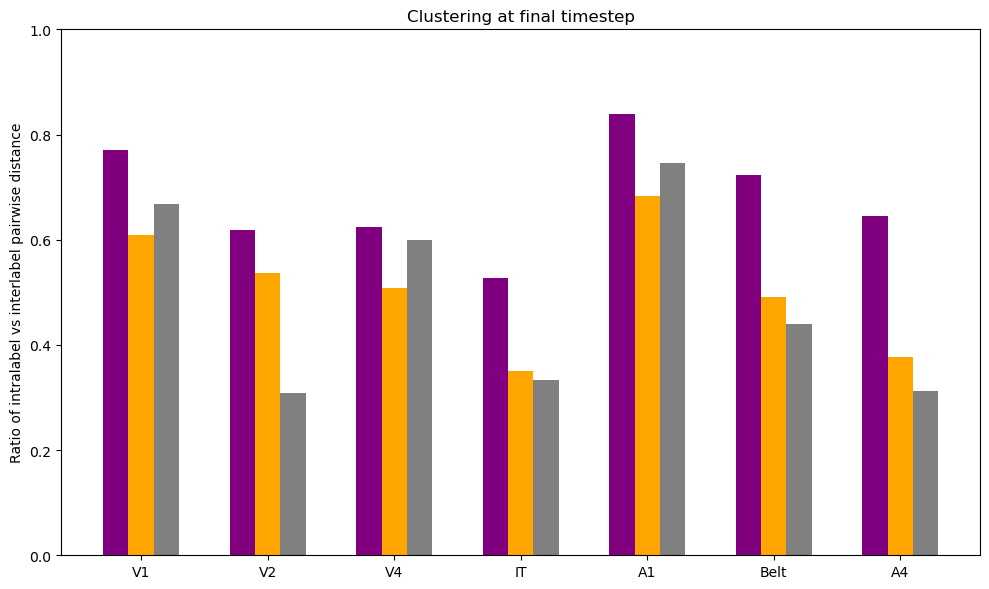

In [40]:
positions = np.arange(len(brainlike_ratios[:, 6]))

# Plotting the bar plots with clustering of bars of the same mean together
fig, ax = plt.subplots(figsize=(10, 6))

# Plot bars for array 1
ax.bar(positions - 0.2, brainlike_ratios[:, 6], width=0.2, color='purple', label='Array 1')

# Plot bars for array 2
ax.bar(positions, mpc_ratios[:, 6], width=0.2, color='orange', label='Array 2')

# Plot bars for array 3
ax.bar(positions + 0.2, random_ratios[:, 6], width=0.2, color='grey', label='Array 3')

# Set ticks and labels
ax.set_xticks(positions)
ax.set_xticklabels(['V1', 'V2', 'V4', 'IT', 'A1', 'Belt', "A4"])
ax.set_title('Clustering at final timestep')
ax.set_ylabel('Ratio of intralabel vs interlabel pairwise distance')
ax.set_ylim([0, 1.0])

plt.tight_layout()
plt.show()

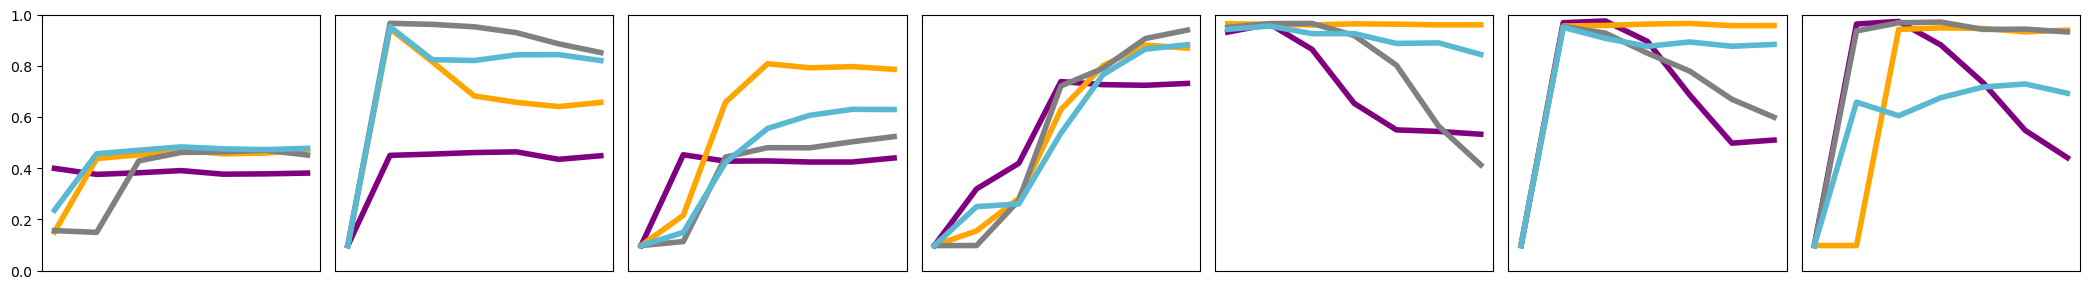

In [21]:
positions = np.arange(len(brainlike_ratios[:, 6]))

# Plotting the bar plots with clustering of bars of the same mean together
fig, ax = plt.subplots(1, 7, figsize=(21, 3))

# Plot bars for array 1
for i, area in enumerate([0, 1, 2, 3, 4, 5, 6]):
    ax[i].plot(brainlike_ratios[area], color='purple', label='Array 1', linewidth=4)
    ax[i].plot(mpc_ratios[area], color='orange', label='Array 2', linewidth=4)
    ax[i].plot(random_ratios[area], color='grey', label='Array 3', linewidth=4)
    ax[i].plot(big_rnn_ratios[area], color='#59B9D2', label='Array 3', linewidth=4)
    
    ax[i].set_ylim([0,1])
    ax[i].set_xticks([])
    if i != 0:
        ax[i].set_yticks([])

# Set ticks and labels
plt.tight_layout()
plt.savefig('figs/fig5_cluster_analysis_match_sratios.pdf')
plt.show()

In [22]:
brainlike_reduced_hstates = pd.read_pickle('dim_red/audio/dim_red_tsne_brainlike_match.npy')
mpc_reduced_hstates = pd.read_pickle('dim_red/audio/dim_red_tsne_MPC_match.npy')
random_reduced_hstates = pd.read_pickle('dim_red/audio/dim_red_tsne_random_match.npy')
big_rnn_reduced_hstates = pd.read_pickle('dim_red/audio/dim_red_tsne_big_rnn_match.npy')

brainlike_ratios = compute_sratios(brainlike_reduced_hstates)
mpc_ratios = compute_sratios(mpc_reduced_hstates)
random_ratios = compute_sratios(random_reduced_hstates)
big_rnn_ratios = compute_sratios(big_rnn_reduced_hstates)

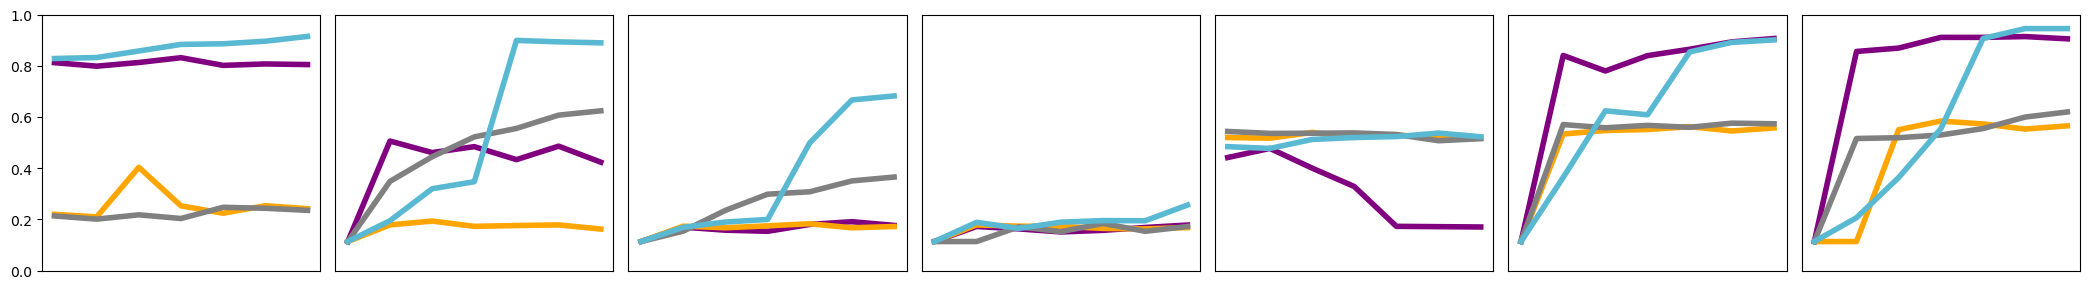

In [23]:
positions = np.arange(len(brainlike_ratios[:, 6]))

# Plotting the bar plots with clustering of bars of the same mean together
fig, ax = plt.subplots(1, 7, figsize=(21, 3))

# Plot bars for array 1
for i, area in enumerate([0, 1, 2, 3, 4, 5, 6]):
    ax[i].plot(brainlike_ratios[area], color='purple', label='Array 1', linewidth=4)
    ax[i].plot(mpc_ratios[area], color='orange', label='Array 2', linewidth=4)
    ax[i].plot(random_ratios[area], color='grey', label='Array 3', linewidth=4)
    ax[i].plot(big_rnn_ratios[area], color='#59B9D2', label='Array 3', linewidth=4)
    
    ax[i].set_ylim([0, 1])
    ax[i].set_xticks([])
    if i != 0:
        ax[i].set_yticks([])

# Set ticks and labels
plt.tight_layout()
plt.savefig('figs/fig5_wFF/fig5_cluster_analysis_AS_sratio.pdf')
plt.show()

### AS2, a unique pain in the ass

In [39]:
from sklearn.cluster import KMeans
from scipy.spatial.distance import cdist

def mean_distance_to_nearest_centroid(data, label, k):
    # Filter data points based on label
    label_data = data[data[:, -1] == label][:, :-1]  # Exclude the label column
    
    # Apply K-means clustering
    kmeans = KMeans(n_clusters=k).fit(label_data)
    centroids = kmeans.cluster_centers_
    
    # Calculate distances between each data point and its nearest centroid
    distances = cdist(label_data, centroids, 'euclidean')
    min_distances = np.min(distances, axis=1)
    
    # Calculate the mean distance for this label
    mean_distance = np.mean(min_distances)
    
    return mean_distance

def compare_mean_distances(data, k):
    labels = np.unique(data[:, -1])  # Extract unique labels
    
    # Calculate mean distance for each label
    label_mean_distances = {}
    for label in labels:
        mean_dist = mean_distance_to_nearest_centroid(data, label, k)
        label_mean_distances[label] = mean_dist
    
    # Calculate mean distance between points of different labels
    interlabel_distances = []
    for i in range(len(labels)):
        for j in range(i+1, len(labels)):
            label_i_data = data[data[:, -1] == labels[i]][:, :-1]
            label_j_data = data[data[:, -1] == labels[j]][:, :-1]
            distances = cdist(label_i_data, label_j_data, 'euclidean')
            interlabel_distances.extend(distances.flatten())
    mean_interlabel_distance = np.mean(interlabel_distances)
    
    # Calculate ratio of mean intralabel distances to mean interlabel distance
    intralabel_distances = np.array(list(label_mean_distances.values()))
    mean_intralabel_distance = np.mean(intralabel_distances)
    #ratio = mean_intralabel_distance / mean_interlabel_distance
    
    return mean_intralabel_distance, mean_interlabel_distance

In [15]:
brainlike_reduced_hstates.shape

torch.Size([7, 7, 400, 4])

In [49]:
data = brainlike_reduced_hstates[3, 5]
silhouette_score(data[:, 0:2], data[:, 2])

-0.05293416

In [46]:
def compute_AS2_ratios(input_data, k=4):
    num_labels = input_data.shape[0]
    ratios_matrix = np.zeros((num_labels, num_labels))
    
    for i in range(num_labels):
        for j in range(num_labels):
            label_mean_distances, mean_interlabel_distance = compare_mean_distances(input_data[i,j], k=k)
            ratio = label_mean_distances/mean_interlabel_distance
            ratios_matrix[j, i] = ratio
    
    return ratios_matrix

In [24]:
brainlike_reduced_hstates = pd.read_pickle('dim_red/audio/dim_red_tsne_brainlike_mismatch.npy')
mpc_reduced_hstates = pd.read_pickle('dim_red/audio/dim_red_tsne_MPC_mismatch.npy')
random_reduced_hstates = pd.read_pickle('dim_red/audio/dim_red_tsne_random_mismatch.npy')
big_rnn_reduced_hstates = pd.read_pickle('dim_red/audio/dim_red_tsne_big_rnn_mismatch.npy')

brainlike_ratios = compute_sratios(brainlike_reduced_hstates, 'audio')
mpc_ratios = compute_sratios(mpc_reduced_hstates, 'audio')
random_ratios = compute_sratios(random_reduced_hstates, 'audio')
big_rnn_ratios = compute_sratios(big_rnn_reduced_hstates, 'audio')

In [ ]:
brainlike_reduced_hstates = pd.read_pickle('dim_red/audio/dim_red_tsne_brainlike_mismatch.npy')
mpc_reduced_hstates = pd.read_pickle('dim_red/audio/dim_red_tsne_MPC_mismatch.npy')
random_reduced_hstates = pd.read_pickle('dim_red/audio/dim_red_tsne_random_mismatch.npy')
big_rnn_reduced_hstates = pd.read_pickle('dim_red/audio/dim_red_tsne_big_rnn_mismatch.npy')

brainlike_ratios = compute_AS2_ratios(brainlike_reduced_hstates)
mpc_ratios = compute_AS2_ratios(mpc_reduced_hstates)
random_ratios = compute_AS2_ratios(random_reduced_hstates)
big_rnn_ratios = compute_AS2_ratios(big_rnn_reduced_hstates)

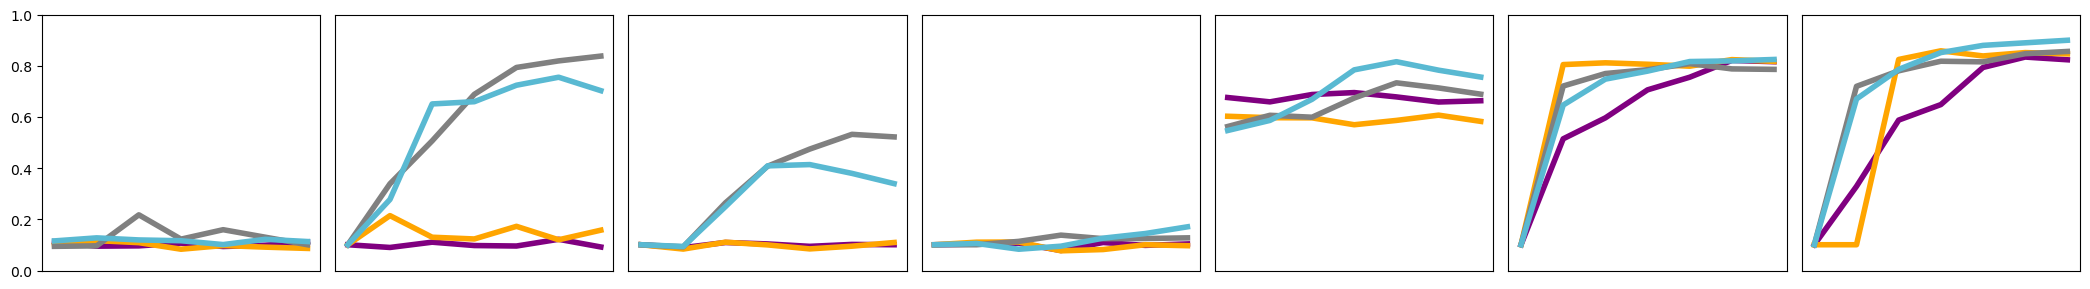

In [26]:
fig, ax = plt.subplots(1, 7, figsize=(21, 3))

# Plot bars for array 1
for i, area in enumerate([0, 1, 2, 3, 4, 5, 6]):
    ax[i].plot(brainlike_ratios[area], color='purple', label='Array 1', linewidth=4)
    ax[i].plot(mpc_ratios[area], color='orange', label='Array 2', linewidth=4)
    ax[i].plot(random_ratios[area], color='grey', label='Array 3', linewidth=4)
    ax[i].plot(big_rnn_ratios[area], color='#59B9D2', label='Array 3', linewidth=4)
    
    ax[i].set_ylim([0, 1])
    ax[i].set_xticks([])
    if i != 0:
        ax[i].set_yticks([])

# Set ticks and labels
plt.tight_layout()
#plt.gca().invert_yaxis()
plt.savefig('figs/fig5_cluster_analysis_AS2_sratio.pdf')
plt.show()

## Legacy Graph

In [41]:
input_nodes = [0, 4, 7] # V1, A1
output_node = [7]
brainlike_graph= Graph('graphs/4task_models/multimodal_brainlike.csv', input_nodes=input_nodes, output_nodes=output_node, reciprocal=True)
mpc_graph = Graph('graphs/4task_models/multimodal_brainlike_MPC.csv', input_nodes=input_nodes, output_nodes=output_node, reciprocal=True)
random_graph = Graph('graphs/4task_models/multimodal_random.csv', input_nodes=input_nodes, output_nodes=output_node, reciprocal=True)
big_rnn_graph = Graph('graphs/4task_models/multimodal_big_rnn.csv', input_nodes=input_nodes, output_nodes=output_node, reciprocal=False)

input_sizes = brainlike_graph.find_input_sizes()
input_dims = brainlike_graph.find_input_dims()

# INIT MODEL
brainlike_model = Architecture(brainlike_graph, input_sizes, input_dims).cuda().float()
mpc_model = Architecture(mpc_graph, input_sizes, input_dims).cuda().float()
random_model = Architecture(random_graph, input_sizes, input_dims).cuda().float()
big_rnn_model = Architecture(big_rnn_graph, input_sizes, input_dims).cuda().float()

/home/mila/m/mashbayar.tugsbayar/.conda/envs/con2model/lib/python3.11/site-packages/torch/nn/init.py:412: UserWarning: Initializing zero-element tensors is a no-op
  warnings.warn("Initializing zero-element tensors is a no-op")


In [5]:
brainlike_reduced_hstates = torch.zeros(3, 4, 7, 7)
mpc_reduced_hstates = torch.zeros(3, 4, 7, 7)
random_reduced_hstates = torch.zeros(3, 4, 7, 7)
big_rnn_reduced_hstates = torch.zeros(3, 4, 7, 7)

for i in range(1, 4):
    brainlike_vs = pd.read_pickle('saved_models/hstates_vs/brainlike_thickness_hstate_composite{:1d}.pt'.format(i))
    mpc_vs = pd.read_pickle('saved_models/hstates_vs/brainlike_MPC_hstate_{:1d}.pt'.format(i))
    random_vs = pd.read_pickle('saved_models/hstates_vs/random2_hstate_{:1d}.pt'.format(i))
    big_rnn_vs = pd.read_pickle('saved_models/hstates_vs/big_rnn_hstate_{:1d}.pt'.format(i))
    
    brainlike_as = pd.read_pickle('saved_models/hstates_as/brainlike_thickness_hstate_{:1d}.pt'.format(i))
    mpc_as = pd.read_pickle('saved_models/hstates_as/brainlike_MPC_hstate_{:1d}.pt'.format(i))
    random_as = pd.read_pickle('saved_models/hstates_as/random2_hstate_{:1d}.pt'.format(i))
    big_rnn_as = pd.read_pickle('saved_models/hstates_as/big_rnn_hstate_{:1d}.pt'.format(i))
    #big_rnn_as = torch.zeros(2, 7, 7)
    
    brainlike_reduced_hstates[i-1] = torch.cat([brainlike_vs, brainlike_as], dim=0)
    mpc_reduced_hstates[i-1] = torch.cat([mpc_vs, mpc_as], dim=0)
    random_reduced_hstates[i-1] = torch.cat([random_vs, random_as], dim=0)
    big_rnn_reduced_hstates[i-1] = torch.cat([big_rnn_vs, big_rnn_as], dim=0)

In [6]:
brainlike_mean, brainlike_std = torch.mean(brainlike_reduced_hstates, dim=0), torch.std(brainlike_reduced_hstates, dim=0)
mpc_mean, mpc_std = torch.mean(mpc_reduced_hstates, dim=0), torch.std(mpc_reduced_hstates, dim=0)
random_mean, random_std = torch.mean(random_reduced_hstates, dim=0), torch.std(random_reduced_hstates, dim=0)
big_rnn_mean, big_rnn_std = torch.mean(big_rnn_reduced_hstates, dim=0), torch.std(big_rnn_reduced_hstates, dim=0)

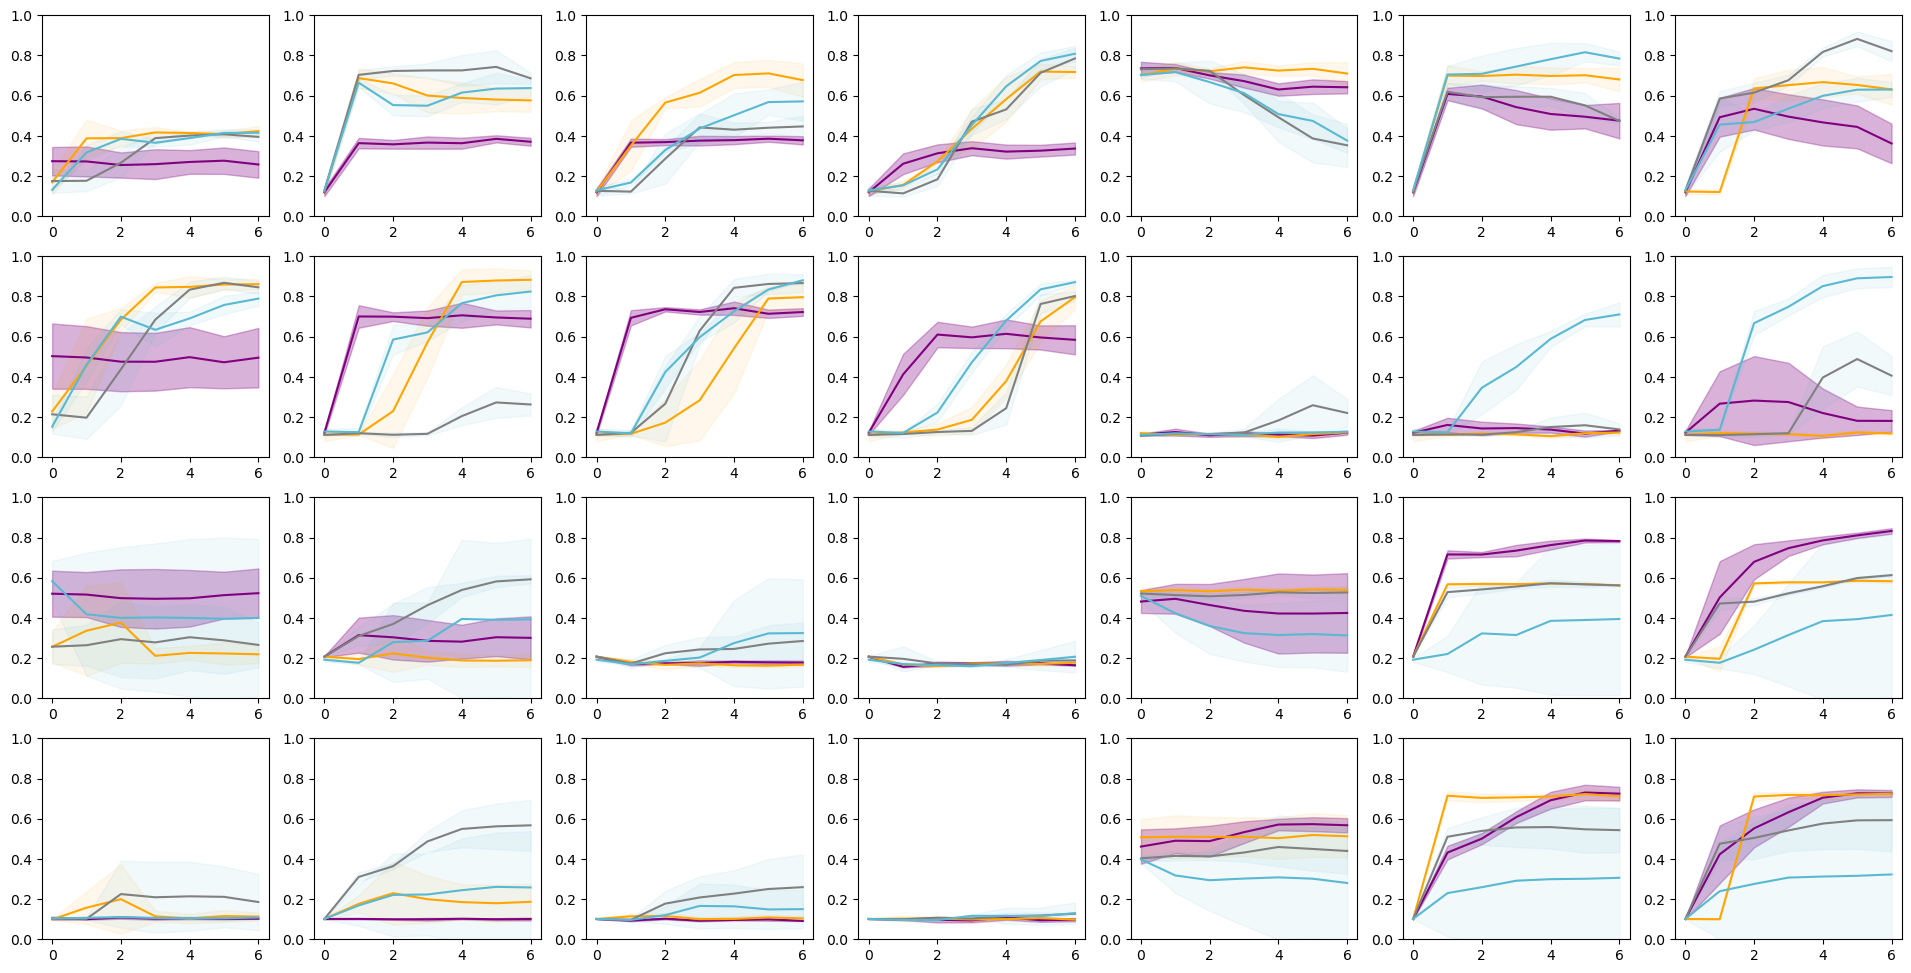

In [7]:
fig, ax = plt.subplots(4, 7, figsize=(24, 12))

x = np.arange(0,7)

for task in range(4):
    for area in range(7):
        ax[task, area].fill_between(x, brainlike_mean[task, area]-brainlike_std[task, area], brainlike_mean[task, area]+brainlike_std[task, area], color='purple', alpha=0.3)
        ax[task, area].plot(brainlike_mean[task, area], label='brainlike', color='purple')

        ax[task, area].fill_between(x, mpc_mean[task, area]-mpc_std[task, area], mpc_mean[task, area]+mpc_std[task, area], color='orange', alpha=0.08)
        ax[task, area].plot(mpc_mean[task, area], label='reverse', color='orange')
        
        ax[task, area].fill_between(x, random_mean[task, area]-random_std[task, area], random_mean[task, area]+random_std[task, area], color='#59B9D2', alpha=0.08)
        ax[task, area].plot(random_mean[task, area], label='random', color='grey')
        
        ax[task, area].fill_between(x, big_rnn_mean[task, area]-big_rnn_std[task, area], big_rnn_mean[task, area]+big_rnn_std[task, area], color='#59B9D2', alpha=0.08)
        ax[task, area].plot(big_rnn_mean[task, area], label='All FF', color='#59B9D2')
        
        ax[task, area].set_ylim(0, 1.0)

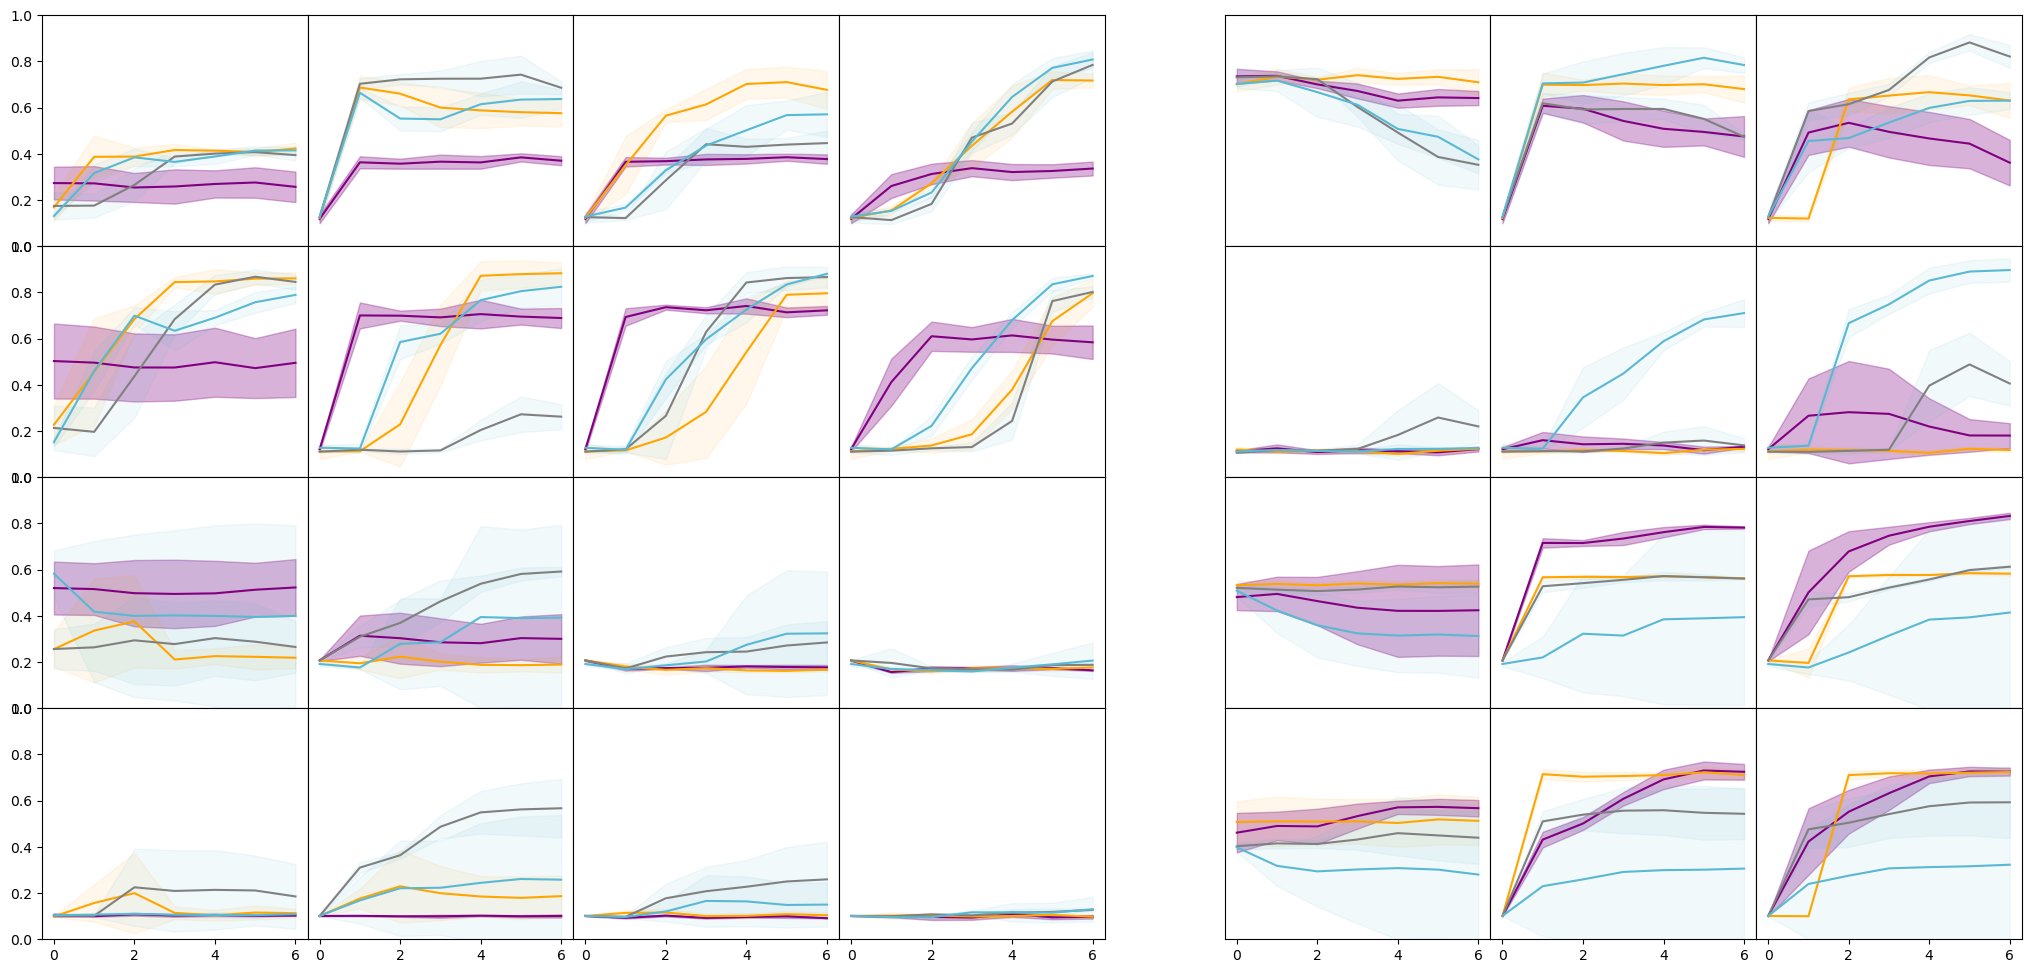

In [8]:
fig, ax = plt.subplots(4, 7, figsize=(24, 12))
plt.subplots_adjust(wspace=0.0, hspace=0.0)  # Remove all spacing between plots

x = np.arange(0, 7)

# Iterate over tasks and areas to plot
for task in range(4):
    for area in range(7):
        # Fill and plot data
        ax[task, area].fill_between(x, brainlike_mean[task, area]-brainlike_std[task, area], brainlike_mean[task, area]+brainlike_std[task, area], color='purple', alpha=0.3)
        ax[task, area].plot(brainlike_mean[task, area], label='brainlike', color='purple')

        ax[task, area].fill_between(x, mpc_mean[task, area]-mpc_std[task, area], mpc_mean[task, area]+mpc_std[task, area], color='orange', alpha=0.08)
        ax[task, area].plot(mpc_mean[task, area], label='reverse', color='orange')
        
        ax[task, area].fill_between(x, random_mean[task, area]-random_std[task, area], random_mean[task, area]+random_std[task, area], color='#59B9D2', alpha=0.08)
        ax[task, area].plot(random_mean[task, area], label='random', color='grey')
        
        ax[task, area].fill_between(x, big_rnn_mean[task, area]-big_rnn_std[task, area], big_rnn_mean[task, area]+big_rnn_std[task, area], color='#59B9D2', alpha=0.08)
        ax[task, area].plot(big_rnn_mean[task, area], label='All FF', color='#59B9D2')
        
        # Set y-axis limits
        ax[task, area].set_ylim(0, 1.0)
        
        # Remove unnecessary ticks
        if area != 0:  # Remove y-ticks except for the first column
            ax[task, area].tick_params(left=False, labelleft=False)
        if task != 3:  # Remove x-ticks except for the last row
            ax[task, area].tick_params(bottom=False, labelbottom=False)

# Add space between the 4th and 5th columns
for task in range(4):
    ax[task, 4].set_position([
        ax[task, 4].get_position().x0 + 0.05,  # Shift to the right
        ax[task, 4].get_position().y0,
        ax[task, 4].get_position().width,
        ax[task, 4].get_position().height
    ])
    for area in range(5, 7):
        ax[task, area].set_position([
            ax[task, area].get_position().x0 + 0.05,
            ax[task, area].get_position().y0,
            ax[task, area].get_position().width,
            ax[task, area].get_position().height
        ])

plt.savefig('figs/latent_correct.pdf')
plt.show()

In [7]:
brainlike_reduced_hstates = torch.zeros(3, 4, 8, 7)
mpc_reduced_hstates = torch.zeros(3, 4, 8, 7)
random_reduced_hstates = torch.zeros(3, 4, 8, 7)
big_rnn_reduced_hstates = torch.zeros(3, 4, 8, 7)

for i in range(1, 4):
    brainlike_vs = pd.read_pickle('saved_models/hstates_avs/brainlike_thickness_hstate_{:1d}.pt'.format(i))
    mpc_vs = pd.read_pickle('saved_models/hstates_avs/brainlike_MPC_hstate_{:1d}.pt'.format(i))
    random_vs = pd.read_pickle('saved_models/hstates_avs/random2_hstate_{:1d}.pt'.format(i))
    #big_rnn_vs = pd.read_pickle('saved_models/hstates_avs/big_rnn_hstate_{:1d}.pt'.format(i))
    
    brainlike_reduced_hstates[i-1] = brainlike_vs
    mpc_reduced_hstates[i-1] = mpc_vs
    random_reduced_hstates[i-1] = random_vs
    #big_rnn_reduced_hstates[i-1] = big_rnn_vs

In [8]:
brainlike_mean, brainlike_std = torch.mean(brainlike_reduced_hstates, dim=0), torch.std(brainlike_reduced_hstates, dim=0)
mpc_mean, mpc_std = torch.mean(mpc_reduced_hstates, dim=0), torch.std(mpc_reduced_hstates, dim=0)
random_mean, random_std = torch.mean(random_reduced_hstates, dim=0), torch.std(random_reduced_hstates, dim=0)
#big_rnn_mean, big_rnn_std = torch.mean(big_rnn_reduced_hstates, dim=0), torch.std(big_rnn_reduced_hstates, dim=0)

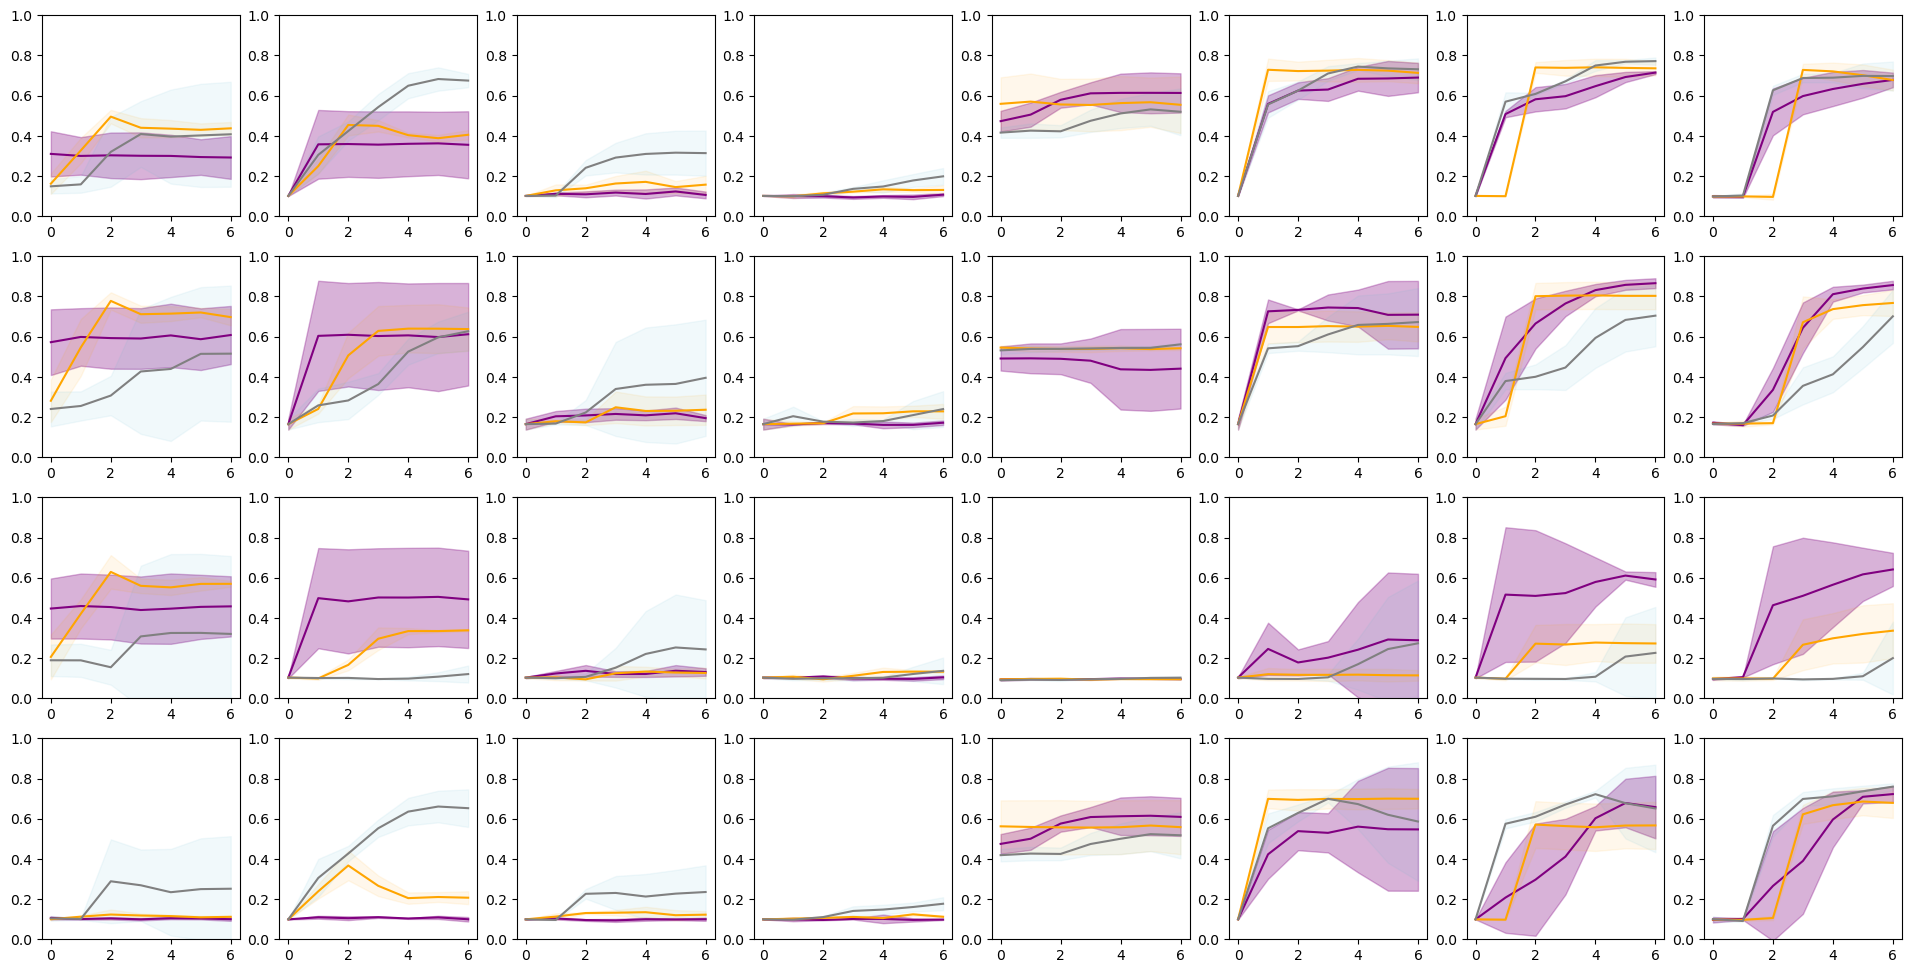

In [13]:
fig, ax = plt.subplots(4, 8, figsize=(24, 12))

x = np.arange(0,7)

for task in range(4):
    for area in range(8):
        ax[task, area].fill_between(x, brainlike_mean[task, area]-brainlike_std[task, area], brainlike_mean[task, area]+brainlike_std[task, area], color='purple', alpha=0.3)
        ax[task, area].plot(brainlike_mean[task, area], label='brainlike', color='purple')

        ax[task, area].fill_between(x, mpc_mean[task, area]-mpc_std[task, area], mpc_mean[task, area]+mpc_std[task, area], color='orange', alpha=0.08)
        ax[task, area].plot(mpc_mean[task, area], label='reverse', color='orange')
        
        ax[task, area].fill_between(x, random_mean[task, area]-random_std[task, area], random_mean[task, area]+random_std[task, area], color='#59B9D2', alpha=0.08)
        ax[task, area].plot(random_mean[task, area], label='random', color='grey')
        
        #ax[task, area].fill_between(x, big_rnn_mean[task, area]-big_rnn_std[task, area], big_rnn_mean[task, area]+big_rnn_std[task, area], color='#59B9D2', alpha=0.08)
        #ax[task, area].plot(big_rnn_mean[task, area], label='All FF', color='#59B9D2')
        
        ax[task, area].set_ylim(0, 1.0)